# Assignment 1 (Due 25 January)

by Fahad Chohan

The goal of this assignment is to write a simple particle simulator. Assume we have $N$ particles with strength $k_j > 0$ at the positions $x_j\in\mathbb{R}^2$, $j=0,\dots, N-1$. Each particle creates a potential at a given point $x$ of strength $V_j(x) = -k_j\log |x-x_j|$. The total potential at a given position $x$ is therefore
$$
V(x) = -\sum_{j=0}^{N-1}k_j\log|x-x_j|.
$$

The following code generates $N$ particle positions and a vector of associated strengths.

In [1]:
!conda install -c conda-forge --yes --verbose pyopencl pocl

Solving environment: ...working... done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/nbuser/anaconda3_501

  added / updated specs: 
    - pocl
    - pyopencl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ocl-icd-2.2.12             |    h14c3975_1002          83 KB  conda-forge
    clangdev-6.0.1             |    h6c845d6_1000       110.1 MB  conda-forge
    pyopencl-2018.2.2          |py36h21de261_1001         643 KB  conda-forge
    llvm-meta-6.0.1            |                0           2 KB  conda-forge
    pocl-1.2                   |    h6bb024c_1002        39.5 MB  conda-forge
    libhwloc-2.0.2             |    h6c845d6_1000         2.6 MB  conda-forge
    conda-4.6.1                |       

In [2]:
import numpy as np
from numba import jit, prange

##number of surce points
N = 100

rand = np.random.RandomState(0) ##array of randoms 
pos = rand.rand(N, 2) ##array ofsources
k = rand.rand(N) ##strength vector

In [3]:
##import pyopencl and create context and queue
import pyopencl as cl
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

Let us plot the corresponding particle positions.

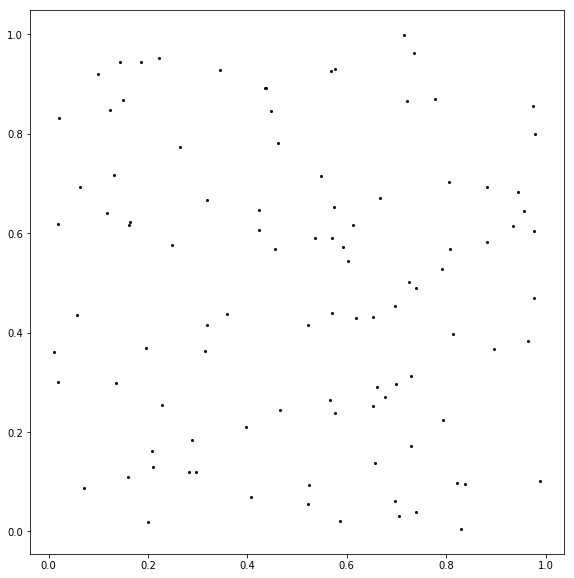

In [4]:
##plot of source points
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(pos[:, 0], pos[:, 1], 'k.', markersize=4)
ax.set_aspect('equal')

Implement the following function **evaluate_field** that evaluates the potential field at a given set of points:

In [5]:
def evaluate_field(evaluation_points, source_positions, strength_vector,
                   implementation='numba'):
    """
    Evaluate a field at a given set of points.
    
    Parameters
    ------------
    evaluation_points : np.ndarray
        A (M, 2) float64 array of M positions that contain the 
        two dimensional points at which to evaluate the field.
    source_positions : np.ndarray
        A (N, 2) float64 array of N source positions that contain
        the source locations
    strength_vector : np.ndarray
        A (N, ) float64 array of the strengths associated with
        each source.
    implementaiton : string
        Either 'numba' or 'opencl' to use a Numba or OpenCL
        implementation.
        
    Returns
    -------------
    A (M, ) float64 vector of the field values at the corresponding
    evaluation points.
    
    """
    if implementation == 'opencl':
        return evaluate_field_opencl(evaluation_points, source_positions,
                                     strength_vector)
    else:
        return evaluate_field_numba(evaluation_points, source_positions,
                                     strength_vector)

def evaluate_field_opencl(evaluation_points, source_positions,
                          strength_vector):
    """OpenCL Implementation"""
    
    kernel = """
    
    __kernel void evaluate_potential(__global double *evaluationPoints,
                                     __global double *sourcePoints,
                                     __global double *strengthVector,
                                     __global double *result)
    {
    
    int gid = get_global_id(0); //row index
    double d_x = 0.0;   //horizontal displacement of source and eval points
    double d_y = 0.0;   //vertical displacement of source and eval points
    double d = 0.0;   //displacement of source and eval points
    double V = 0.0;   //potential variable
    
    //for loop which applies potential equation
    for (int i=0; i<N; i++){
        d_x = evaluationPoints[2*gid] - sourcePoints[2*i];
        d_y = evaluationPoints[2*gid + 1] - sourcePoints[2*i + 1];
        d = sqrt(pow(d_x,2) + pow(d_y,2));
        V += - strengthVector[i] * log(d);
    }
    
    //result to be outputted
    result[gid] = V;
    
    
    }
    
    """ 
    
    ##number of surce and eval points
    n_eval_points = evaluation_points.shape[0]
    n_source_positions = source_positions.shape[0]
    
    ##mem flags
    mf = cl.mem_flags
    
    ##create buffers to read and write
    eval_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=evaluation_points)
    source_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=source_positions)
    strength_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=strength_vector)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size=evaluation_points.shape[0] * 8)
    
    ##build program
    prg = cl.Program(ctx, kernel)
    prg.build(options=['-D', 'N={0}'.format(N)])
    potential_kernel = prg.evaluate_potential
    
    potential_kernel(queue, (n_eval_points, ), (1, ),
                     eval_buffer, source_buffer, strength_buffer, result_buffer)
    
    ##read result
    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                      0, (n_eval_points, ), np.double)
    queue.finish()
    
    return result

@jit(nopython=True)
def evaluate_field_numba(evaluation_points, source_positions,
                          strength_vector):
    '''numba implementation'''
    
    ##create array of zeros with dimensions as eval points
    V = np.zeros(len(evaluation_points))
    
    ##for loop in whch potential is calculated
    for i in prange(0, len(evaluation_points)):
        for j in prange(0, len(source_positions)):
            r = evaluation_points[i] - source_positions[j]  
            d = np.abs( np.sqrt(r[0]**2 + r[1]**2))
            V[i] += - strength_vector[j] * np.log(d)
            
    return V
        
            

To implement this function it makes sense not to write everything as one single function, but to have two implementations, **evaluate_field_opencl** and **evaluate_field_numba**, which are chosen depending on the *implementation* parameter.

To allow the marker to check the correctess of your implementation run the following test.

In [6]:
evaluation_points = np.array([[1.5, 1.3], [1.8, 1.6]], dtype='float64')

result_numba = evaluate_field(evaluation_points, pos, k, implementation='numba')
result_opencl = evaluate_field(evaluation_points, pos, k, implementation='opencl')

Obviously, both results should be identical. For OpenCL you should work with *float64* data types. The code must run using the pocl CPU OpenCL driver provided on Microsoft Azure Notebook.

Finally, we want to make timing measurements and also plot the results. Let us define a grid of evaluation points in the unit square.

In [7]:
Nx = 100
Ny = 100
xpoints, ypoints = np.mgrid[0 : 1: 1j * Nx, 0 : 1: 1j * Ny]
evaluation_points = np.vstack([xpoints.ravel(), ypoints.ravel()]).T

We also need our usual timer class.

In [8]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

Now run the following two timing experiments:

In [9]:
with Timer() as t:
    result_numba = evaluate_field(evaluation_points, pos, k, implementation='numba')
print(t.interval)

with Timer() as t:
    result_opencl = evaluate_field(evaluation_points, pos, k, implementation='opencl')
print(t.interval)

1.8643872737884521
1.292065143585205


Finally, we want to plot the results. We plot the logs since the result will be large close to the poles.

In [10]:
result_numba = np.log10(np.abs(result_numba.reshape(Nx, Ny)))
result_opencl = np.log10(np.abs(result_opencl.reshape(Nx, Ny)))

Text(0.5, 1.0, 'OpenCL')

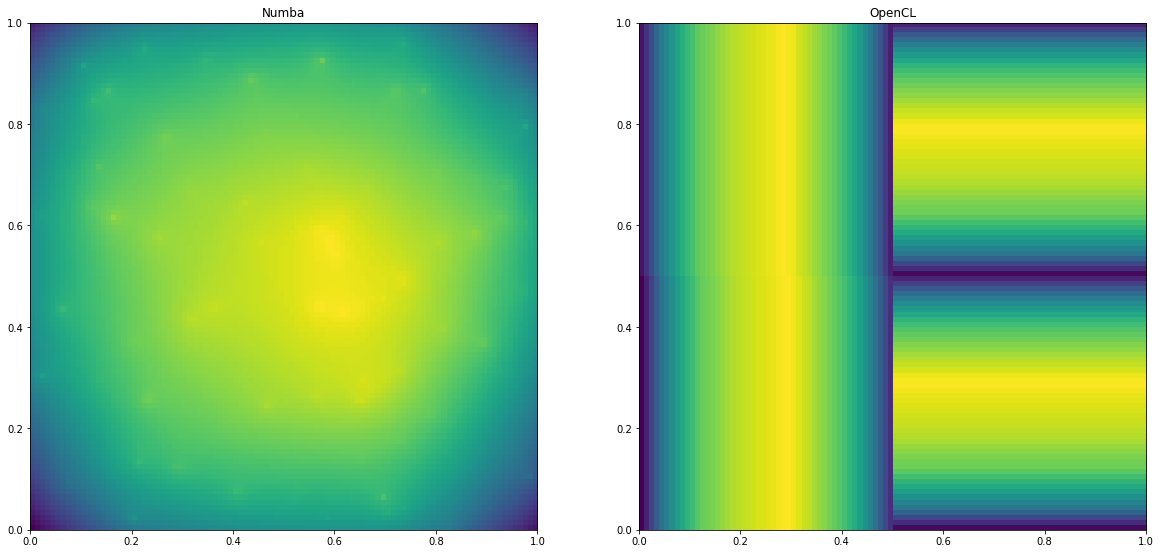

In [11]:
figure = plt.figure(figsize=(20, 20))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

ax1.imshow(result_numba.T, extent=[0, 1, 0, 1], origin='lower')
ax1.set_aspect('equal')
ax1.set_title('Numba')

ax2.imshow(result_opencl.T, extent=[0, 1, 0, 1], origin='lower')
ax2.set_aspect('equal')
ax2.set_title('OpenCL')


## Marking

A correct Numba implementation is worth 50%. A correct OpenCL implementation is worth a further 20%.
Coding style (clean code following PEP8 standard and good comments) is worth 10%.
Finally, I am comparing timing results from all implementations on my machine. The solutions from all students will be ranked and given bonus
marks depending on their ranking (20 bonus marks for the fastest solution, 0 bonus marks for the slowest solution). Bonus marks will only be
added for students who provide a correct Numba and OpenCL implementation.

**Make sure that your implementation of the evaluate_field function exactly follows the given signature. Changing the signature results in
0 marks being given for the assignment.**

To submit your assignment a corresponding submission link on Moodle will be enabled. Please submit one Jupyter notebook. Multi-file solutions will not be accepted.